# Model selection 

The goal of this notebook is to start using scikit-learn for model selection. We will use a simple classification algorithm, the k-nearest-neighbor, on the `vinho verde` data set, and try to find the best value for k.

You will also learn how to standardize features, and use the `pandas` library for simple data manipulation.

This notebook was created by [Chloé-Agathe Azencott](http://cazencott.info).

Throughout the lab, do not hesitate to refer heavily to the [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html).

## 1. Loading our data science libraries

In [3]:
%pylab inline
import pandas

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

## 2. Loading the data

The `vinho verde` data set contains physico-chemical information on a number of Portuguese wines, as well as their rating by human tasters. 

Our goal is to use these data to automatically predict the rating of a wine, so as to assist oenologists, improve wine production, and target the taste of niche consumers.

This data set has been made available on the UCI archive repository (it is one of the oldest and most well-known repository of ML problems).

It is available from: http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/ (but already in your repository; we will focus on white wines here).

In [4]:
data = pandas.read_csv('data/winequality-white.csv', sep=";")

In [7]:
type(data)

pandas.core.frame.DataFrame

We have loaded the data in a _pandas DataFrame_ object. Let us examine what information is available:

In [8]:
print data.head()

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

The data contains 12 columns. The first 10 (fixed acidity -- alcohol) are physico-chemical features of the wines; the last one is their rating (or quality).

Let us extract from this data a numpy array that contains the design matrix X:

In [22]:
X = data.values[:, :-1]
print X.shape

(4898, 11)


__Question 1:__ Extract from this data a one-dimensional numpy array that contains the labels y.

In [24]:
# TODO

(4898,)


Let us now plot a histogram of the values taken by each of our features:

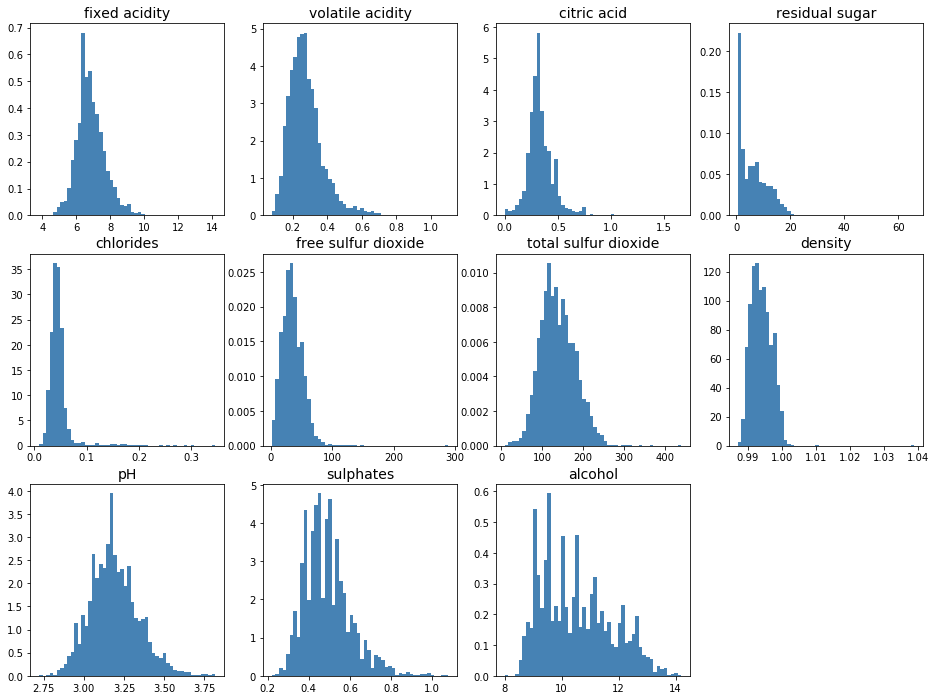

In [26]:
# create a figure of size 16x12
fig = plt.figure(figsize=(16, 12))

for feat_idx in range(X.shape[1]):
    # create a subplot in the (feat_idx+1) position of a 3x4 grid
    ax = fig.add_subplot(3, 4, (feat_idx+1))
    # plot the histogram of feat_idx
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue',
                normed=True, edgecolor='none')
    # use the name of the feature as a title for each histogram
    ax.set_title(data.columns[feat_idx], fontsize=14)

__Question 2:__
What are the ranges of values taken by the different features? What do you think is going to happen when one computes the euclidean distance between two samples: will the `free sulfur dioxide` be accounted for in a manner similar to the `sulphates`? How is this going to affect the k-nearest-neighbor algorithm?

__Answer:__

## 3. Model selection

### 3.1 Train and test sets

Because some classes of wine quality have very few samples, we will start by transforming this problem into a binary classification problem. Our goal will then be to separate good wines (rating at least 6) from poor wines (rating less than 6).

In [34]:
y_class = np.where(y<6, 0, 1)

Let us start by separating our data into a training and a test set (containing 30% of the data). We will use cross-validation _on the training set_ to select the value of k, and we will report the performance of the selected model on the test set, as an approximation to the _generalization performance_ of our model.

This can be done with scikit-learn's [model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [35]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y_class,
                                    test_size=0.3 # 30% des données dans le jeu de test
                                    )

In [36]:
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(3428, 11) (1470, 11) (3428,) (1470,)


### 3.2 Feature standardization

As we have observed in Section 2, the features need to be _standardized_ so as to be more or less on the same scale. We will achieve this by forcing them to have 0 mean and standard deviation 1. They will therefore all have the same importance to the eyes of a distance-based learning algorithm.

We will use scikit-learn's [preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [37]:
from sklearn import preprocessing

# Create a standardizer object and fit it to the training data.
std_scale = preprocessing.StandardScaler().fit(X_train)

# Apply the standardization to the training and the test data.
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

__Question 3:__ Why did we fit the standardizer (i.e. computed the mean and standard deviation for each feature) on the training set only?

__Answer:__

__Question 4:__ Visualize the scaled data again to check that the standardization had the intended effect.

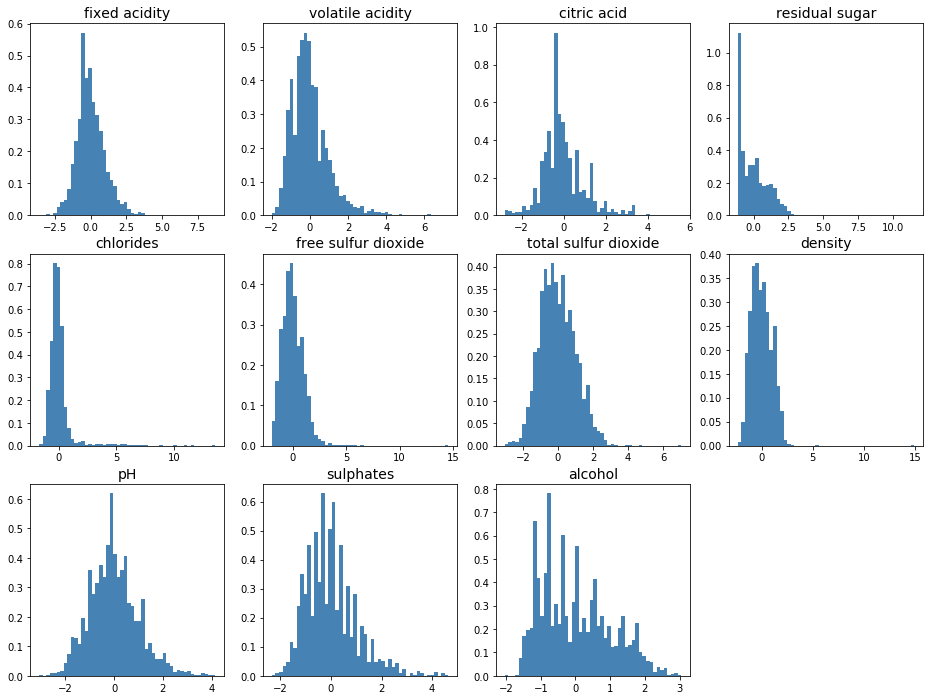

In [38]:
# TODO

### 3.3 Model selection by cross-validation

We will now choose the optimal value of k (the number of neighbors) in a k-nearest neighbor algorithm using a cross-validation procedure _on the training set_.

This can be done using scikit-learn's [model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In addition, we will need scikit-learn's (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)[neighbors.KNeighborsClassifier] to implement a k-nearest neighbors.

In [39]:
from sklearn import neighbors

# Set the values of the hyperparameter to test
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Pick a score to optimize, here accuracy, that is, the proportion of correct predictions
score = 'accuracy'

# Build a kNN classifier with hyperparameter search by cross-validation:
clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), # a kNN
                                   param_grid, # hyperparameters to test
                                   cv=5, # number of folds of the cross-validation
                                   scoring=score # score to optimize
                                  )

# Optimize the classifier on the standardized training data
clf.fit(X_train_std, y_train)

# Print optimal hyperparameter(s)
print "Best hyperparameter(s) on the training set:",
print clf.best_params_

# Print performance
print "Cross-validation results:"
for mean, std, params in zip(clf.cv_results_['mean_test_score'], # mean score on test set
                             clf.cv_results_['std_test_score'], # standard deviation
                             clf.cv_results_['params'] # value of the hyperparameter
                            ):
    print "\t%s = %0.3f (+/-%0.03f) for %r" % (score, # performance
                                               mean, # mean score
                                               std * 2, # error bar
                                               params # hyperparameter
                                              )

Best hyperparameter(s) on the training set: {'n_neighbors': 9}
Cross-validation results:
	accuracy = 0.755 (+/-0.022) for {'n_neighbors': 3}
	accuracy = 0.751 (+/-0.009) for {'n_neighbors': 5}
	accuracy = 0.754 (+/-0.032) for {'n_neighbors': 7}
	accuracy = 0.757 (+/-0.044) for {'n_neighbors': 9}
	accuracy = 0.754 (+/-0.041) for {'n_neighbors': 11}
	accuracy = 0.756 (+/-0.035) for {'n_neighbors': 13}
	accuracy = 0.756 (+/-0.040) for {'n_neighbors': 15}


## 3.4 Generalization performance

We can now report the performance of our best model (it is automatically stored in `clf`) on the test set.

We will use scikit-learn's [metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module to this end.

In [42]:
from sklearn import metrics

y_pred = clf.predict(X_test_std)
print "\nAccuracy on the test set: %0.3f" % metrics.accuracy_score(y_test, y_pred)


Accuracy on the test set: 0.780


__Question 5:__ Compute the full confusion matrix for our best model, on the test set.

In [44]:
# TODO

[[277 208]
 [115 870]]
